# Exploring Ensemble Methods

In this assignment, we will explore the use of boosting. We will use the pre-implemented gradient boosted trees in Turi Create. You will:

* Use SFrames to do some feature engineering.
* Train a boosted ensemble of decision-trees (gradient boosted trees) on the LendingClub dataset.
* Predict whether a loan will default along with prediction probabilities (on a validation set).
* Evaluate the trained model and compare it with a baseline.
* Find the most positive and negative loans using the learned model.
* Explore how the number of trees influences classification performance.

Copyright ©2018 Emily Fox.  All rights reserved.  Permission is hereby granted to students registered for University of Washington CSE/STAT 416 for use solely during Spring Quarter 2018 for purposes of the course.  No other use, copying, distribution, or modification is permitted without prior written consent. Copyrights for third-party components of this work must be honored.  Instructors interested in reusing these course materials should contact the author.

Let's get started!

## Fire up Turi Create

In [1]:
import turicreate as tc

# Load LendingClub dataset

We will be using the [LendingClub](https://www.lendingclub.com/) data. As discussed earlier, the [LendingClub](https://www.lendingclub.com/) is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors.

Just like we did in previous assignments, we will build a classification model to predict whether or not a loan provided by lending club is likely to default.

In the decision trees assignment, we walked through several steps of data preparation, for example:
- converting the target column to [-1, +1]
- selecting a subset of the features that we think will be important
- skipping observations with missing values
- sampling to balance the target classes

To save time in this assignment, we have done these steps in advance, and saved the `SFrame` in a new file called `clean-lending-club-data.gl`, which we can load in and immediately work with. If you are interested in these data preparation steps, please refer back to A4.

In [2]:
loans_data = tc.SFrame('/data/clean-lending-club-data.gl')

Let's quickly explore what the dataset looks like. First, let's print out the column names to see what features we have in this dataset. We have done this in previous assignments, so we won't belabor this here.

In [3]:
loans_data.column_names()

['safe_loans',
 'grade',
 'sub_grade_num',
 'short_emp',
 'emp_length_num',
 'home_ownership',
 'dti',
 'purpose',
 'payment_inc_ratio',
 'delinq_2yrs',
 'delinq_2yrs_zero',
 'inq_last_6mths',
 'last_delinq_none',
 'last_major_derog_none',
 'open_acc',
 'pub_rec',
 'pub_rec_zero',
 'revol_util',
 'total_rec_late_fee',
 'int_rate',
 'total_rec_int',
 'annual_inc',
 'funded_amnt',
 'funded_amnt_inv',
 'installment']

### Define features and target

In [4]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies 
            'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

## Split data into training and validation sets

We split the data into training data and validation data. We used `seed=1` to make sure everyone gets the same results. We will use the validation data to help us select model parameters.

In [5]:
train_data, validation_data = loans_data.random_split(.8, seed=1)

# Gradient boosted tree classifier

Gradient boosted trees are a powerful variant of boosting methods; they have been used to win many [Kaggle](https://www.kaggle.com/) competitions, and have been widely used in industry.  We will explore the predictive power of multiple decision trees as opposed to a single decision tree.

**Additional reading:** If you are interested in gradient boosted trees, here is some additional reading material:
* [Turi user guide (the examples use GraphLab Create, which is essentially the same as Turi Create](https://turi.com/learn/userguide/supervised-learning/boosted_trees_classifier.html)
* [Advanced material on boosted trees](http://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf)


We will now train models to predict `safe_loans` using the features above. In this section, we will experiment with training an ensemble of 5 trees. To cap the ensemble classifier at 5 trees, we call the function with **max_iterations=5** (recall that each iterations corresponds to adding a tree). We set `validation_set=None` to make sure everyone gets the same results.

In [6]:
model_5 = tc.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 5)

Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 37219

Number of classes           : 2

Number of feature columns   : 24

Number of unpacked features : 24

+-----------+--------------+-------------------+-------------------+

| Iteration | Elapsed Time | Training-accuracy | Training-log_loss |

+-----------+--------------+-------------------+-------------------+

| 1         | 0.065475     | 0.657541          | 0.657139          |

| 2         | 0.126548     | 0.656976          | 0.636157          |

| 3         | 0.185942     | 0.664983          | 0.623206          |

| 4         | 0.245511     | 0.668476          | 0.613783          |

| 5         | 0.304158     | 0.673339          | 0.606229          |

+-----------+--------------+-------------------+-------------------+

## Evaluating the model on the validation data

Recall that the accuracy is defined as follows:
$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

Evaluate the accuracy of the **model_5** on the **validation_data**.

**Hint**: Use the `.evaluate()` method in the model.

In [7]:
accuracy = model_5.evaluate(validation_data, metric='accuracy')
print(accuracy)

{'accuracy': 0.66813873330461}


Calculate the number of **false positives** made by the model.

In [8]:
predict = model_5.predict(validation_data)
validation_data['predict'] = predict
false_positives = len(validation_data[(validation_data['safe_loans'] == -1) & (validation_data['predict'] == 1)])
print(false_positives)

1618


**Q1**: What is the number of **false positives** on the **validation_data**?

Calculate the number of **false negatives** made by the model.

In [9]:
false_neg = len(validation_data[(validation_data['safe_loans'] == 1) & (validation_data['predict'] == -1)])
false_neg

1463

**Q2**: What is the number of **false negatives** on the **validation_data**? 

## Comparison with decision trees

In the earlier assignment, we saw that the prediction accuracy of the decision trees was around **0.64** (rounded), which is lower than the accuracy of **model_5**.

Here, we quantify the benefit of the extra increase in accuracy of **model_5** in comparison with a single decision tree from the original decision tree assignment.

As we explored in the earlier assignment, we calculated the cost of the mistakes made by the model. We again consider the same costs as follows:

* **False negatives**: Assume a cost of \$10,000 per false negative.
* **False positives**: Assume a cost of \$20,000 per false positive.

Assume that the number of false positives and false negatives for the learned decision tree was

* **False negatives**: 1936
* **False positives**: 1503

Using the costs defined above and the number of false positives and false negatives for the decision tree, we can calculate the total cost of the mistakes made by the decision tree model as follows:

```
cost = $10,000 * 1936  + $20,000 * 1503 = $49,420,000
```

The total cost of the mistakes of the model is $49.42M. That is a **lot of money**!.

**Q3**: Using the same costs of the false positives and false negatives, what is the cost of the mistakes made by the boosted tree model (**model_5**) as evaluated on the **validation_set**?

In [10]:
cost = 10000 * false_neg + 20000 * false_positives
cost

46990000

**Reminder**: Compare the cost of the mistakes made by the boosted trees model with the decision tree model. The extra improvement in prediction accuracy can translate to several million dollars!  And, it was so easy to get by simply boosting our decision trees.

## Most positive & negative loans.

In this section, we will find the loans that are most likely to be predicted **safe**. We can do this in a few steps:

* **Step 1**: Use the **model_5** (the model with 5 trees) and make **probability predictions** for all the loans in the **validation_data**.
* **Step 2**: Similar to what we did in the very first assignment, add the probability predictions as a column called **predictions** into the validation_data.
* **Step 3**: Sort the data (in descreasing order) by the probability predictions.

Start here with **Step 1** & **Step 2**. Make predictions using **model_5** for examples in the **validation_data**. Use `output_type = probability`.

In [11]:
validation_data['predictions'] = model_5.predict(validation_data, 
                                output_type='probability')

**Checkpoint:** For each row, the probabilities should be a number in the range **[0, 1]**. We have provided a simple check here to make sure your answers are correct.

In [12]:
print "Your loans      : %s\n" % validation_data['predictions'].head(4)
print "Expected answer : %s" % [0.4492515948736132, 0.6119100103640573,
                                0.3835981314851436, 0.3693306705994325]

Your loans      : [0.44925159215927124, 0.6119099855422974, 0.38359811902046204, 0.3693307042121887]

Expected answer : [0.4492515948736132, 0.6119100103640573, 0.3835981314851436, 0.3693306705994325]


Now, we are ready to go to **Step 3**. You can now use the `prediction` column to sort the loans in **validation_data** (in descending order) by prediction probability. Find the top 5 loans with the highest probability of being predicted as a **safe loan**.

In [13]:
most_positive_loans = validation_data.sort('predictions', ascending=False)[0:5]
most_positive_loans

Columns:
	safe_loans	int
	grade	str
	sub_grade_num	float
	short_emp	int
	emp_length_num	int
	home_ownership	str
	dti	float
	purpose	str
	payment_inc_ratio	float
	delinq_2yrs	int
	delinq_2yrs_zero	int
	inq_last_6mths	int
	last_delinq_none	int
	last_major_derog_none	int
	open_acc	int
	pub_rec	int
	pub_rec_zero	int
	revol_util	float
	total_rec_late_fee	float
	int_rate	float
	total_rec_int	float
	annual_inc	int
	funded_amnt	int
	funded_amnt_inv	int
	installment	float
	predict	int
	predictions	float

Rows: 5

Data:
+------------+-------+---------------+-----------+----------------+----------------+
| safe_loans | grade | sub_grade_num | short_emp | emp_length_num | home_ownership |
+------------+-------+---------------+-----------+----------------+----------------+
|     1      |   A   |      0.2      |     0     |       11       |    MORTGAGE    |
|     1      |   A   |      0.4      |     0     |       4        |    MORTGAGE    |
|     1      |   A   |      0.6      |     0     |       11       |    MORTGAGE    |
|     1      |   A   |      0.2      |     0     |       11       |    MORTGAGE    |
|     1      |   A   |      0.2      |     0     |       11       |      OWN       |
+------------+-------+---------------+-----------+----------------+----------------+
+-------+----------------+-------------------+-------------+------------------+
|  dti  |    purpose     | payment_inc_ratio | delinq_2yrs | delinq_2yrs_zero |
+-------+----------------+-------------------+-------------+------------------+
|  4.21 |  credit_card   |      0.955726     |      0      |        1         |
| 12.76 |      car       |       1.7376      |      0      |        1         |
|  2.4  |      car       |      2.49545      |      0      |        1         |
|  6.47 | major_purchase |       1.131       |      1      |        0         |
|  0.69 |      car       |      3.17372      |      0      |        1         |
+-------+----------------+-------------------+-------------+------------------+
+----------------+------------------+-----------------------+----------+---------+
| inq_last_6mths | last_delinq_none | last_major_derog_none | open_acc | pub_rec |
+----------------+------------------+-----------------------+----------+---------+
|       2        |        1         |           1           |    9     |    0    |
|       2        |        1         |           1           |    11    |    0    |
|       0        |        1         |           1           |    6     |    0    |
|       0        |        0         |           1           |    9     |    0    |
|       0        |        1         |           1           |    4     |    0    |
+----------------+------------------+-----------------------+----------+---------+
+--------------+------------+--------------------+----------+-----+
| pub_rec_zero | revol_util | total_rec_late_fee | int_rate | ... |
+--------------+------------+--------------------+----------+-----+
|      1       |    7.9     |        0.0         |   6.39   | ... |
|      1       |    5.5     |        0.0         |   6.76   | ... |
|      1       |    0.0     |        0.0         |   6.17   | ... |
|      1       |    9.6     |        0.0         |   5.42   | ... |
|      1       |    9.1     |        0.0         |   6.03   | ... |
+--------------+------------+--------------------+----------+-----+
[5 rows x 27 columns]

**Q4**: What grades are the top 5 loans?
- ABAAB
- BBBAA
- BACAA
- AAAAA
- BBCBA

Let us repeat this excercise to find the top 5 loans (in the **validation_data**) with the **lowest probability** of being predicted as a **safe loan**:

In [14]:
most_negative_loans = validation_data.sort('predictions', ascending=True)[0:5]
most_negative_loans

Columns:
	safe_loans	int
	grade	str
	sub_grade_num	float
	short_emp	int
	emp_length_num	int
	home_ownership	str
	dti	float
	purpose	str
	payment_inc_ratio	float
	delinq_2yrs	int
	delinq_2yrs_zero	int
	inq_last_6mths	int
	last_delinq_none	int
	last_major_derog_none	int
	open_acc	int
	pub_rec	int
	pub_rec_zero	int
	revol_util	float
	total_rec_late_fee	float
	int_rate	float
	total_rec_int	float
	annual_inc	int
	funded_amnt	int
	funded_amnt_inv	int
	installment	float
	predict	int
	predictions	float

Rows: 5

Data:
+------------+-------+---------------+-----------+----------------+----------------+
| safe_loans | grade | sub_grade_num | short_emp | emp_length_num | home_ownership |
+------------+-------+---------------+-----------+----------------+----------------+
|     -1     |   D   |      0.8      |     0     |       3        |      RENT      |
|     -1     |   C   |      0.8      |     1     |       0        |    MORTGAGE    |
|     -1     |   B   |      1.0      |     0     |       5        |      RENT      |
|     -1     |   C   |      0.4      |     0     |       4        |      RENT      |
|     -1     |   C   |      0.2      |     0     |       5        |      RENT      |
+------------+-------+---------------+-----------+----------------+----------------+
+-------+--------------------+-------------------+-------------+------------------+
|  dti  |      purpose       | payment_inc_ratio | delinq_2yrs | delinq_2yrs_zero |
+-------+--------------------+-------------------+-------------+------------------+
|  8.95 |   small_business   |       16.727      |      0      |        1         |
| 17.37 |  home_improvement  |      12.5753      |      0      |        1         |
| 29.42 | debt_consolidation |      14.3733      |      0      |        1         |
|  8.4  |    credit_card     |      11.8779      |      0      |        1         |
| 30.17 | debt_consolidation |      13.5391      |      0      |        1         |
+-------+--------------------+-------------------+-------------+------------------+
+----------------+------------------+-----------------------+----------+---------+
| inq_last_6mths | last_delinq_none | last_major_derog_none | open_acc | pub_rec |
+----------------+------------------+-----------------------+----------+---------+
|       2        |        1         |           1           |    7     |    0    |
|       0        |        1         |           1           |    8     |    0    |
|       0        |        0         |           1           |    14    |    0    |
|       0        |        1         |           1           |    9     |    0    |
|       1        |        1         |           1           |    7     |    0    |
+----------------+------------------+-----------------------+----------+---------+
+--------------+------------+--------------------+----------+-----+
| pub_rec_zero | revol_util | total_rec_late_fee | int_rate | ... |
+--------------+------------+--------------------+----------+-----+
|      1       |    41.6    |      16.7025       |   15.2   | ... |
|      1       |    46.1    |       18.86        |  15.31   | ... |
|      1       |    57.5    |      20.9132       |  14.09   | ... |
|      1       |    60.0    |       34.64        |  15.31   | ... |
|      1       |    80.7    |      19.7362       |  14.33   | ... |
+--------------+------------+--------------------+----------+-----+
[5 rows x 27 columns]

**Q5:** What grades are the bottom 5 loans?
- DCCCC
- CBCCB
- AAABC
- DDDDD
- DCBCC

## Effect of adding more trees

In this assignment, we will train 5 different ensemble classifiers in the form of gradient boosted trees. We will train models with 10, 50, 100, 200, and 500 trees.  We use the **max_iterations** parameter in the boosted tree module. 

Fill in the code below to populate the `models` list with models using the given numbers of trees (**Warning:** This could take a couple of minutes to run. Consider adding `print` statements to track your progress)

In [25]:

models = []
tree_counts = [10, 50, 100, 200, 500]
# TODO: populate models with gradient boosted trees
model_num = 0
for count in tree_counts:
    print count
    models.append(tc.boosted_trees_classifier.create(train_data, validation_set=None, target=target, features = features, max_iterations = count))
    model_num = model_num +1
    

10
0


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 37219

Number of classes           : 2

Number of feature columns   : 24

Number of unpacked features : 24

+-----------+--------------+-------------------+-------------------+

| Iteration | Elapsed Time | Training-accuracy | Training-log_loss |

+-----------+--------------+-------------------+-------------------+

| 1         | 0.068199     | 0.657541          | 0.657139          |

| 2         | 0.133852     | 0.656976          | 0.636157          |

| 3         | 0.196761     | 0.664983          | 0.623206          |

| 4         | 0.257131     | 0.668476          | 0.613783          |

| 5         | 0.320024     | 0.673339          | 0.606229          |

| 6         | 0.383709     | 0.677262          | 0.600809          |

+-----------+--------------+-------------------+-------------------+

50
1


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 37219

Number of classes           : 2

Number of feature columns   : 24

Number of unpacked features : 24

+-----------+--------------+-------------------+-------------------+

| Iteration | Elapsed Time | Training-accuracy | Training-log_loss |

+-----------+--------------+-------------------+-------------------+

| 1         | 0.059784     | 0.657541          | 0.657139          |

| 2         | 0.121727     | 0.656976          | 0.636157          |

| 3         | 0.182394     | 0.664983          | 0.623206          |

| 4         | 0.241325     | 0.668476          | 0.613783          |

| 5         | 0.306037     | 0.673339          | 0.606229          |

| 6         | 0.366387     | 0.677262          | 0.600809          |

| 11        | 0.658587     | 0.690131          | 0.582282          |

| 25        | 1.476319     | 0.724334          | 0.544715          |

| 50        | 2.956777     | 0.753943          | 0.507820          |

+-----------+--------------+-------------------+-------------------+

100
2


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 37219

Number of classes           : 2

Number of feature columns   : 24

Number of unpacked features : 24

+-----------+--------------+-------------------+-------------------+

| Iteration | Elapsed Time | Training-accuracy | Training-log_loss |

+-----------+--------------+-------------------+-------------------+

| 1         | 0.063118     | 0.657541          | 0.657139          |

| 2         | 0.122410     | 0.656976          | 0.636157          |

| 3         | 0.189346     | 0.664983          | 0.623206          |

| 4         | 0.250292     | 0.668476          | 0.613783          |

| 5         | 0.313408     | 0.673339          | 0.606229          |

| 6         | 0.378343     | 0.677262          | 0.600809          |

| 11        | 0.670174     | 0.690131          | 0.582282          |

| 25        | 1.476823     | 0.724334          | 0.544715          |

| 50        | 2.943952     | 0.753943          | 0.507820          |

| 51        | 3.002260     | 0.755501          | 0.506300          |

| 75        | 4.409928     | 0.777963          | 0.478113          |

| 100       | 5.927935     | 0.799565          | 0.452256          |

+-----------+--------------+-------------------+-------------------+

200
3


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 37219

Number of classes           : 2

Number of feature columns   : 24

Number of unpacked features : 24

+-----------+--------------+-------------------+-------------------+

| Iteration | Elapsed Time | Training-accuracy | Training-log_loss |

+-----------+--------------+-------------------+-------------------+

| 1         | 0.063854     | 0.657541          | 0.657139          |

| 2         | 0.121998     | 0.656976          | 0.636157          |

| 3         | 0.187670     | 0.664983          | 0.623206          |

| 4         | 0.247386     | 0.668476          | 0.613783          |

| 5         | 0.307380     | 0.673339          | 0.606229          |

| 6         | 0.371361     | 0.677262          | 0.600809          |

| 11        | 0.679160     | 0.690131          | 0.582282          |

| 25        | 1.523880     | 0.724334          | 0.544715          |

| 50        | 2.977532     | 0.753943          | 0.507820          |

| 51        | 3.032733     | 0.755501          | 0.506300          |

| 75        | 4.466650     | 0.777963          | 0.478113          |

| 100       | 5.912775     | 0.799565          | 0.452256          |

| 101       | 5.969372     | 0.799860          | 0.451931          |

| 125       | 7.381751     | 0.820280          | 0.425868          |

| 150       | 8.833673     | 0.834628          | 0.406161          |

| 175       | 10.316248    | 0.850748          | 0.386342          |

| 200       | 11.775145    | 0.863564          | 0.369538          |

+-----------+--------------+-------------------+-------------------+

500
4


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 37219

Number of classes           : 2

Number of feature columns   : 24

Number of unpacked features : 24

+-----------+--------------+-------------------+-------------------+

| Iteration | Elapsed Time | Training-accuracy | Training-log_loss |

+-----------+--------------+-------------------+-------------------+

| 1         | 0.061210     | 0.657541          | 0.657139          |

| 2         | 0.123967     | 0.656976          | 0.636157          |

| 3         | 0.179452     | 0.664983          | 0.623206          |

| 4         | 0.241082     | 0.668476          | 0.613783          |

| 5         | 0.311738     | 0.673339          | 0.606229          |

| 6         | 0.370252     | 0.677262          | 0.600809          |

| 11        | 0.662953     | 0.690131          | 0.582282          |

| 25        | 1.491666     | 0.724334          | 0.544715          |

| 50        | 2.955542     | 0.753943          | 0.507820          |

| 51        | 3.019291     | 0.755501          | 0.506300          |

| 75        | 4.429079     | 0.777963          | 0.478113          |

| 100       | 5.900764     | 0.799565          | 0.452256          |

| 101       | 5.959443     | 0.799860          | 0.451931          |

| 125       | 7.378167     | 0.820280          | 0.425868          |

| 150       | 8.860344     | 0.834628          | 0.406161          |

| 175       | 10.283087    | 0.850748          | 0.386342          |

| 200       | 11.725546    | 0.863564          | 0.369538          |

| 225       | 13.173232    | 0.873505          | 0.354368          |

| 250       | 14.661523    | 0.883769          | 0.340257          |

| 275       | 16.164483    | 0.894597          | 0.323590          |

| 300       | 17.665475    | 0.907010          | 0.307725          |

| 325       | 19.121346    | 0.916575          | 0.295360          |

| 350       | 20.583249    | 0.925146          | 0.281916          |

| 375       | 22.065609    | 0.934093          | 0.268026          |

| 400       | 23.497585    | 0.939413          | 0.257453          |

| 425       | 24.979996    | 0.945968          | 0.246981          |

| 450       | 26.399184    | 0.950267          | 0.239107          |

| 475       | 27.843660    | 0.956635          | 0.227256          |

| 500       | 29.325875    | 0.961767          | 0.217013          |

+-----------+--------------+-------------------+-------------------+

## Compare accuracy on entire validation set

Now we will compare the predicitve accuracy of our models on the validation set. Evaluate the **accuracy** of the 10, 50, 100, 200, and 500 tree models on the **validation_data**. Use the `evaluate` method.

In [28]:
accuracies = []
for model in models:
    accuracies.append(model.evaluate(validation_data, metric='accuracy'))
accuracies

[{'accuracy': 0.6727703576044808},
 {'accuracy': 0.6907582938388626},
 {'accuracy': 0.6917277035760449},
 {'accuracy': 0.684510986643688},
 {'accuracy': 0.6718009478672986}]

**Q6:** Which model has the **best** accuracy on the **validation_data**?
- 10 tree
- 50 tree
- 100 tree
- 200 tree
- 500 tree

**Q7:** Is it always true that the model with the most trees will perform best on test data?
- yes
- no

## Plot the training and validation error vs. number of trees

Recall from the lecture that the classification error is defined as

$$
\mbox{classification error} = 1 - \mbox{accuracy} 
$$

In this section, we will plot the **training and validation errors versus the number of trees** to get a sense of how these models are performing. We will compare the 10, 50, 100, 200, and 500 tree models. We will use [matplotlib](https://matplotlib.org/index.html) in order to visualize the plots. 

First, run the following method to use as graphing code.

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In order to plot the classification errors (on the **train_data** and **validation_data**) versus the number of trees, we will need lists of these accuracies, which we get by applying the method `.evaluate`. 

Let us start with **Step 1**. Write code to compute the classification error on the **train_data** for models with 10, 20, 50, 100 200, and 500 trees, and store these errors in a list `training_errors`.

In [49]:
training_errors = []
# TODO: calucalte the training error for each of the models
                                               
for model in models:
    acc = model.evaluate(train_data, metric='accuracy')
    training_errors.append(1.0 - acc.get('accuracy')) 
training_errors
    

[0.31174937531905744,
 0.24605712136274482,
 0.20043526155995595,
 0.13643569144791634,
 0.03823316048254921]

Now, onto **Step 2**. Write code to compute the classification error on the **validation_data** for models 10, 20, 50, 100 200, and 500 trees, saving this into a different list `validation_errors`.

In [50]:
validation_errors = []
# TODO: calucalte the validation error for each of the models
for model in models:
    acc = model.evaluate(validation_data, metric='accuracy')
    validation_errors.append(1.0 - acc.get('accuracy')) 
validation_errors

[0.3272296423955192,
 0.30924170616113744,
 0.30827229642395515,
 0.31548901335631196,
 0.3281990521327014]

Now, we will plot the `training_errors` and `validation_errors` versus the number of trees. We will compare the 10, 50, 100, 200, and 500 tree models. We provide some plotting code to visualize the plots within this notebook. 

Run the following code to visualize the plots.

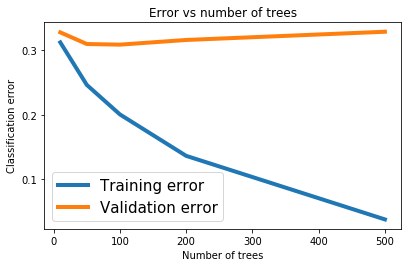

In [51]:
plt.plot(tree_counts, training_errors, linewidth=4.0, label='Training error')
plt.plot(tree_counts, validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')

**Q8**: Does the training error reduce as the number of trees increases?
- yes
- no
- yes and no

**Q9**: Is it always true that the validation error will reduce as the number of trees increases?
- yes
- no